Мы имеем CSV файл со значениями глюкозы такого вида:
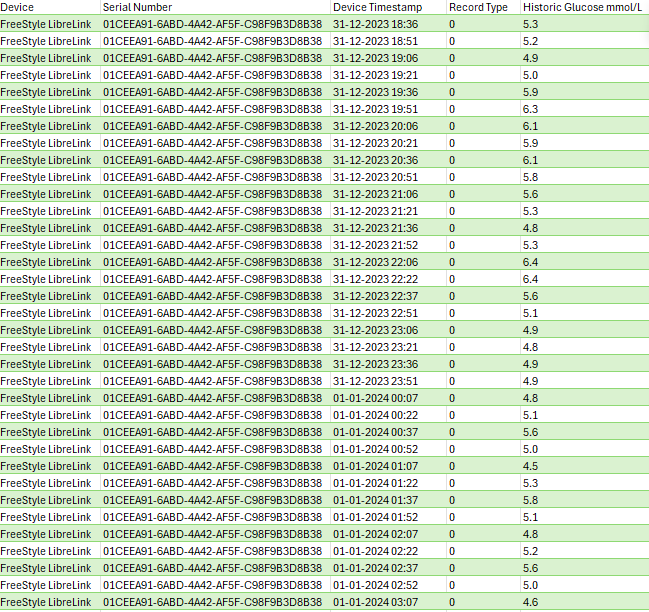


И данные о питании, имеющие следующий вид:
1 день = 2 файла:
- .json, где хранится время приемов пищи
- .txt с основными характеристиками приемов пищи

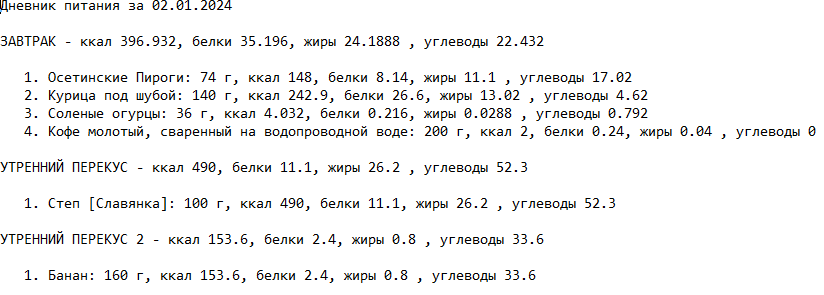


# Функции

In [4]:
# Функция для парсинга данных из txt и json файлов
def read_meal_data(txt_file, json_file):
  import pandas as pd
  import json
  import datetime

  # Функция для парсинга данных из txt файла
  def read_txt_file(txt_file):
      # Обработка данных из текстового файла
      meals = {}
      with open(txt_file, 'r', encoding='utf-8') as file:
          lines = file.readlines()

          date_str = lines[0].strip().split('за ')[1]

          current_meal = None
          for line in lines:
              if 'ЗАВТРАК' in line or 'ОБЕД' in line or 'УЖИН' in line or 'УТРЕННИЙ ПЕРЕКУС' in line or 'ДНЕВНОЙ ПЕРЕКУС' in line or 'ВЕЧЕРНИЙ ПЕРЕКУС' in line:
                  current_meal = line.strip().split(' - ')[0]
                  meals[current_meal] = {'ккал': 0, 'белки': 0, 'жиры': 0, 'углеводы': 0, 'дата': date_str}
                  values = [el.split(' ') for el in line.split(',')]
                  #print(values)
                  meals[current_meal]['ккал'] += float(values[0][-1])
                  meals[current_meal]['белки'] += float(values[1][-1])
                  meals[current_meal]['жиры'] += float(values[2][-2])
                  meals[current_meal]['углеводы'] += float(values[3][-1].strip())

      return meals

  # Функция для парсинга данных из json файла
  def read_json_file(json_file):
      # Обработка данных из JSON файла
      with open(json_file, 'r', encoding='utf-8') as file:
          data = json.load(file)
      times = {item['fi']: item['t'] for item in data['diaryItemsToObject']['menu'] if 't' in item}
      return times

  # Функция для объединения json и txt данных
  def merge_data(meals, times):
      # Объединение данных в DataFrame
      df = pd.DataFrame.from_dict(meals, orient='index')
      df['Время'] = times.values()
      df['Дата и время'] = df['дата'] + ' ' + df['Время']
      df['Дата и время'] = pd.to_datetime(df['Дата и время'], format='%d.%m.%Y %H:%M')
      df = df.drop(columns=['дата', 'Время'])
      return df

  # Чтение и обработка данных
  times = read_json_file(json_file)
  meals = read_txt_file(txt_file)

  # Создание и вывод DataFrame
  return merge_data(meals, times)

In [5]:
# Функция позволяющая считывать несколько txt и json
def read_multiple_meal_data(path, start_date, days=10):
  import os
  from datetime import datetime, timedelta
  import pandas as pd

  # Путь к папке с файлами
  folder_path = path

  # Начальная дата. Нужно устанавливать самостоятельно
  start_date = datetime(2023, 12, 31)

  # Количество дней
  days = days

  res_df = pd.DataFrame()

  # Перебор файлов попарно
  for i in range(days):
      # Форматирование даты в строку
      date_str = (start_date + timedelta(days=i)).strftime('%Y-%m-%d')

      # Имя файлов
      json_file = f'ДневникПитанияЗа{date_str}.json'
      txt_file = f'ДневникПитанияЗа{date_str}.txt'

      # Полные пути к файлам
      json_path = os.path.join(folder_path, json_file)
      txt_path = os.path.join(folder_path, txt_file)

      # Проверка наличия файлов
      if i == 10:
        print(json_path, txt_path)
      if os.path.exists(json_path) and os.path.exists(txt_path):
          print(f'Обработка файлов: {json_file} и {txt_file}')
          df_small = read_meal_data(txt_path, json_path)
          res_df = pd.concat([res_df, df_small], ignore_index=True)

      else:
          print(f'Файлы {json_file} и {txt_file} не найдены.')

  return res_df

# IMPORT, EDA, PREPARATION


## import, parsing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import random

In [9]:
# Считывание и обработка csv файла 1
glu_data = pd.read_csv('/content/cgm data 1.csv',
                   header=1,
                   usecols=['Device Timestamp', 'Record Type', 'Historic Glucose mmol/L', 'Scan Glucose mmol/L']
                   )
glu_data = glu_data[glu_data['Record Type'] != 6]
glu_data['Scan Glucose mmol/L'] = glu_data['Scan Glucose mmol/L'].fillna(glu_data['Historic Glucose mmol/L'])
glu_data = glu_data.drop(columns=['Historic Glucose mmol/L', 'Record Type']).reset_index(drop=True)
glu_data['Device Timestamp'] = pd.to_datetime(glu_data['Device Timestamp'], format='%d-%m-%Y %H:%M')
glu_data = glu_data.sort_values(by='Device Timestamp')
glu_data

,Device Timestamp,Scan Glucose mmol/L
0,2023-12-31 18:36:00,5.3
634,2023-12-31 18:36:00,5.5
1,2023-12-31 18:51:00,5.2
635,2023-12-31 18:58:00,5.0
2,2023-12-31 19:06:00,4.9
...,...,...
630,2024-01-08 09:22:00,4.9
631,2024-01-08 09:37:00,4.9
632,2024-01-08 09:52:00,5.1
633,2024-01-08 10:07:00,4.9


In [10]:
# Считывание данных о питании
meal_data = read_multiple_meal_data('/content/', 1, 20)
meal_data['Дата и время'] = pd.to_datetime(meal_data['Дата и время'])
meal_data['ккал'] = meal_data['ккал'].astype(np.float64)
meal_data['белки'] = meal_data['белки'].astype(np.float64)
meal_data['жиры'] = meal_data['жиры'].astype(np.float64)
meal_data['углеводы'] = meal_data['углеводы'].astype(np.float64)

Файлы ДневникПитанияЗа2023-12-31.json и ДневникПитанияЗа2023-12-31.txt не найдены.
Обработка файлов: ДневникПитанияЗа2024-01-01.json и ДневникПитанияЗа2024-01-01.txt
Обработка файлов: ДневникПитанияЗа2024-01-02.json и ДневникПитанияЗа2024-01-02.txt
Обработка файлов: ДневникПитанияЗа2024-01-03.json и ДневникПитанияЗа2024-01-03.txt
Обработка файлов: ДневникПитанияЗа2024-01-04.json и ДневникПитанияЗа2024-01-04.txt
Обработка файлов: ДневникПитанияЗа2024-01-05.json и ДневникПитанияЗа2024-01-05.txt
Обработка файлов: ДневникПитанияЗа2024-01-06.json и ДневникПитанияЗа2024-01-06.txt
Обработка файлов: ДневникПитанияЗа2024-01-07.json и ДневникПитанияЗа2024-01-07.txt
Обработка файлов: ДневникПитанияЗа2024-01-08.json и ДневникПитанияЗа2024-01-08.txt
Обработка файлов: ДневникПитанияЗа2024-01-09.json и ДневникПитанияЗа2024-01-09.txt
/content/ДневникПитанияЗа2024-01-10.json /content/ДневникПитанияЗа2024-01-10.txt
Обработка файлов: ДневникПитанияЗа2024-01-10.json и ДневникПитанияЗа2024-01-10.txt
Обрабо

## shorting, merging

In [11]:
# Удалиние близких приёмов пищи
shortened_meal_data = meal_data.copy()
shortened_meal_data['Разница во времени'] = shortened_meal_data['Дата и время'].diff()
shortened_meal_data = shortened_meal_data[shortened_meal_data['Разница во времени'] >= datetime.timedelta(hours=2, minutes=30)].reset_index()
shortened_meal_data.drop(columns=['Разница во времени', 'index'], inplace=True)
print(f'было: {len(meal_data)}, стало: {len(shortened_meal_data)}')
shortened_meal_data.head()

было: 48, стало: 33


,ккал,белки,жиры,углеводы,Дата и время
0,1782.145,49.362,124.3530,139.989,2024-01-01 15:01:00
1,638.200,42.690,38.1900,30.300,2024-01-01 18:34:00
2,396.932,35.196,24.1888,22.432,2024-01-02 10:10:00
3,153.600,2.400,0.8000,33.600,2024-01-02 13:42:00
4,798.320,37.930,65.0250,40.780,2024-01-02 18:43:00


In [13]:
# Совмещение глю + меал
merged_df = pd.DataFrame(columns=glu_data.columns.tolist() + shortened_meal_data.columns.tolist())
used = []
# Объединение DataFrame по ближайшему времени
for index, row1 in glu_data.iterrows():
    timestamp1 = row1['Device Timestamp']

    closest_row = shortened_meal_data.iloc[(shortened_meal_data['Дата и время'] - timestamp1).abs().argsort()[0]]
    timestamp2 = closest_row['Дата и время']

    if abs((timestamp2 - timestamp1).total_seconds()) <= 450:
      if timestamp2 not in used:
          merged_df = pd.concat([merged_df, pd.concat([row1, closest_row]).to_frame().T], ignore_index=True)
          used.append(timestamp2)
      else:
        merged_df = pd.concat([merged_df, row1.to_frame().T], ignore_index=True)
    else:
      merged_df = pd.concat([merged_df, row1.to_frame().T], ignore_index=True)



merged_df.head()

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время
0,2023-12-31 18:36:00,5.3,NaN,NaN,NaN,NaN,NaT
1,2023-12-31 18:36:00,5.5,NaN,NaN,NaN,NaN,NaT
2,2023-12-31 18:51:00,5.2,NaN,NaN,NaN,NaN,NaT
3,2023-12-31 18:58:00,5.0,NaN,NaN,NaN,NaN,NaT
4,2023-12-31 19:06:00,4.9,NaN,NaN,NaN,NaN,NaT


Text(0.5, 1.0, 'CGM1')

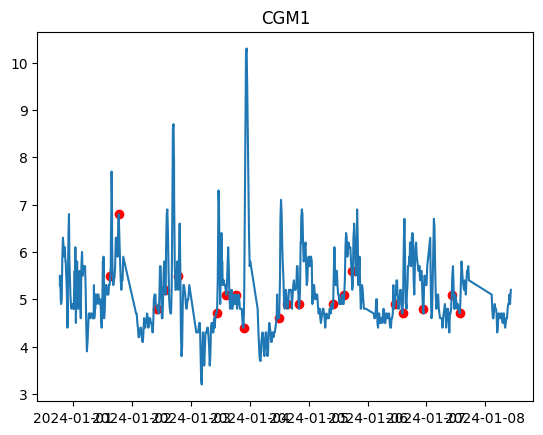

In [14]:
plt.plot(merged_df['Device Timestamp'].iloc[:917], merged_df['Scan Glucose mmol/L'].iloc[:917])
plt.scatter(merged_df[merged_df['ккал'].notnull()]['Device Timestamp'].iloc[:20], merged_df[merged_df['ккал'].notnull()]['Scan Glucose mmol/L'].iloc[:20], c='r')
plt.title('CGM1')

In [16]:
# Оставим в датасете только те значения, которые в интервали [-2, 9] от приема пищи
selected_indices = []
for index in merged_df.dropna().index:
    selected_indices.extend(range(index - 2, index + 9))

# Фильтрация исходного датасета по выбранным индексам
result_df = merged_df.loc[selected_indices].reset_index().drop(columns=['index'])

result_df.head(15)

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время
0,2024-01-01 14:43:00,5.3,NaN,NaN,NaN,NaN,NaT
1,2024-01-01 14:53:00,5.3,NaN,NaN,NaN,NaN,NaT
2,2024-01-01 15:08:00,5.5,1782.145,49.362,124.353,139.989,2024-01-01 15:01:00
3,2024-01-01 15:22:00,5.7,NaN,NaN,NaN,NaN,NaT
4,2024-01-01 15:23:00,6.2,NaN,NaN,NaN,NaN,NaT
5,2024-01-01 15:38:00,7.1,NaN,NaN,NaN,NaN,NaT
6,2024-01-01 15:40:00,7.7,NaN,NaN,NaN,NaN,NaT
7,2024-01-01 15:52:00,6.9,NaN,NaN,NaN,NaN,NaT
8,2024-01-01 15:53:00,6.2,NaN,NaN,NaN,NaN,NaT
9,2024-01-01 16:08:00,5.4,NaN,NaN,NaN,NaN,NaT


## calculating basis, max, auc

In [17]:
# AGGREGATION (basis 30 minutes)
result_df_basis = result_df.copy()
# Создание столбца для среднего значения глюкозы
result_df_basis['Avg Glucose'] = pd.Series(dtype='float64')

# Проход по каждой записи
for i in range(len(result_df_basis)):
    if not pd.isnull(result_df_basis.loc[i, 'ккал']):
        # Нахождение двух предыдущих записей с глюкозой
        prev_records = result_df_basis.loc[i-2:i, 'Scan Glucose mmol/L'].dropna()
        result_df_basis.loc[i, 'Avg Glucose'] = prev_records.mean()

# Вывод результатов
result_df_basis

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время,Avg Glucose
0,2024-01-01 14:43:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN
1,2024-01-01 14:53:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN
2,2024-01-01 15:08:00,5.5,1782.145,49.362,124.353,139.989,2024-01-01 15:01:00,5.366667
3,2024-01-01 15:22:00,5.7,NaN,NaN,NaN,NaN,NaT,NaN
4,2024-01-01 15:23:00,6.2,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...
215,2024-01-07 14:35:00,5.6,NaN,NaN,NaN,NaN,NaT,NaN
216,2024-01-07 14:50:00,5.4,NaN,NaN,NaN,NaN,NaT,NaN
217,2024-01-07 15:05:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN
218,2024-01-07 15:20:00,5.2,NaN,NaN,NaN,NaN,NaT,NaN


In [18]:
# AGGREGATION (MAX GLU)
result_df_max = result_df_basis.copy()
result_df_max['Glucose max raise in Next 8 Rows'] = result_df_max['Scan Glucose mmol/L'].rolling(9, min_periods=1).max().shift(-8) - result_df_max['Avg Glucose']
result_df_max

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время,Avg Glucose,Glucose max raise in Next 8 Rows
0,2024-01-01 14:43:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN
1,2024-01-01 14:53:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,2024-01-01 15:08:00,5.5,1782.145,49.362,124.353,139.989,2024-01-01 15:01:00,5.366667,2.333333
3,2024-01-01 15:22:00,5.7,NaN,NaN,NaN,NaN,NaT,NaN,NaN
4,2024-01-01 15:23:00,6.2,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...
215,2024-01-07 14:35:00,5.6,NaN,NaN,NaN,NaN,NaT,NaN,NaN
216,2024-01-07 14:50:00,5.4,NaN,NaN,NaN,NaN,NaT,NaN,NaN
217,2024-01-07 15:05:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN
218,2024-01-07 15:20:00,5.2,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [19]:
# AGGREGATION (iAUC)
result_df_iauc = result_df_max.copy()
result_df_iauc['iAUC'] = pd.Series(dtype='float64')

# Проход по каждой записи
for i in range(len(result_df_iauc)):
  glucose_values = []

  # Проверка, является ли запись моментом приема пищи
  if not pd.isnull(result_df_iauc.loc[i, 'ккал']):
    base_glucose = result_df_iauc.loc[i, 'Avg Glucose']
    for j in range(1, 9):
      # Рассчет iAUC
      glucose_values.append(result_df_iauc.loc[i+j, 'Scan Glucose mmol/L'])

    # Сохранение значения в столбец
    result_df_iauc.loc[i, 'iAUC'] = (glucose_values - base_glucose).sum()

result_df_iauc

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время,Avg Glucose,Glucose max raise in Next 8 Rows,iAUC
0,2024-01-01 14:43:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,2024-01-01 14:53:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2024-01-01 15:08:00,5.5,1782.145,49.362,124.353,139.989,2024-01-01 15:01:00,5.366667,2.333333,7.566667
3,2024-01-01 15:22:00,5.7,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,2024-01-01 15:23:00,6.2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
215,2024-01-07 14:35:00,5.6,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
216,2024-01-07 14:50:00,5.4,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
217,2024-01-07 15:05:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
218,2024-01-07 15:20:00,5.2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


# FEATURE ENGINE

In [20]:
# categorical time
def time_category(timestamp):
    hour = timestamp.hour

    if 6 <= hour < 12:
        return 'утро'
    elif 12 <= hour < 18:
        return 'день'
    elif 18 <= hour < 24:
        return 'вечер'
    else:
        return 'ночь'

# Добавление категории времени к строкам без пропущенных значений
result_df['Time of Day'] = result_df['Device Timestamp'].apply(lambda x: time_category(x) if not pd.isnull(x) else None)

result_df.head()

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время,Time of Day
0,2024-01-01 14:43:00,5.3,NaN,NaN,NaN,NaN,NaT,день
1,2024-01-01 14:53:00,5.3,NaN,NaN,NaN,NaN,NaT,день
2,2024-01-01 15:08:00,5.5,1782.145,49.362,124.353,139.989,2024-01-01 15:01:00,день
3,2024-01-01 15:22:00,5.7,NaN,NaN,NaN,NaN,NaT,день
4,2024-01-01 15:23:00,6.2,NaN,NaN,NaN,NaN,NaT,день


In [21]:
# FEATURE carb prop
result_carp_prop = result_df_iauc.copy()
result_carp_prop['carb prop'] = result_carp_prop['углеводы'] / result_carp_prop[['белки', 'жиры', 'углеводы']].sum(axis=1).replace({'0':np.nan, 0:np.nan}) * 100
result_carp_prop

,Device Timestamp,Scan Glucose mmol/L,ккал,белки,жиры,углеводы,Дата и время,Avg Glucose,Glucose max raise in Next 8 Rows,iAUC,carb prop
0,2024-01-01 14:43:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,2024-01-01 14:53:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,2024-01-01 15:08:00,5.5,1782.145,49.362,124.353,139.989,2024-01-01 15:01:00,5.366667,2.333333,7.566667,44.624551
3,2024-01-01 15:22:00,5.7,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,2024-01-01 15:23:00,6.2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
215,2024-01-07 14:35:00,5.6,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
216,2024-01-07 14:50:00,5.4,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
217,2024-01-07 15:05:00,5.3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
218,2024-01-07 15:20:00,5.2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [22]:
# Оставим в датасете только те данные, которые мы будем подавать на вход модели
data_to_model = result_carp_prop.drop(columns=['Device Timestamp', 'Scan Glucose mmol/L', 'Дата и время', 'Avg Glucose']).dropna(axis=0)
#result_df_iauc[['ккал', 'белки', 'жиры', 'углеводы', 'Glucose max raise in Next 8 Rows', 'iAUC', 'Time of Day']].dropna().corr(numeric_only=False)
data_to_model

,ккал,белки,жиры,углеводы,Glucose max raise in Next 8 Rows,iAUC,carb prop
2,1782.145,49.362,124.353,139.989,2.333333,7.566667,44.624551
13,638.2,42.69,38.19,30.3,0.366667,-5.366667,27.253103
24,396.932,35.196,24.1888,22.432,0.833333,1.566667,27.417352
35,153.6,2.4,0.8,33.6,1.600000,4.300000,91.304348
46,798.32,37.93,65.025,40.78,1.033333,-4.033333,28.371656
57,700.36,13.006,31.904,89.52,2.633333,10.266667,66.592279
68,750.472,45.061,57.621,27.049,0.900000,1.200000,20.850067
79,5.36,0.0,0.008,1.848,0.133333,-0.433333,99.568966
90,1001.4,20.784,34.868,146.701,5.833333,30.266667,72.497566
101,520.7,12.22,14.53,84.85,2.500000,11.700000,76.030466


In [23]:
data_to_model['ккал'] = data_to_model['ккал'].astype(np.float16)
data_to_model['белки'] = data_to_model['белки'].astype(np.float16)
data_to_model['жиры'] = data_to_model['жиры'].astype(np.float16)
data_to_model['углеводы'] = data_to_model['углеводы'].astype(np.float16)
data_to_model['carb prop'] = data_to_model['carb prop'].astype(np.float16)

## visualize

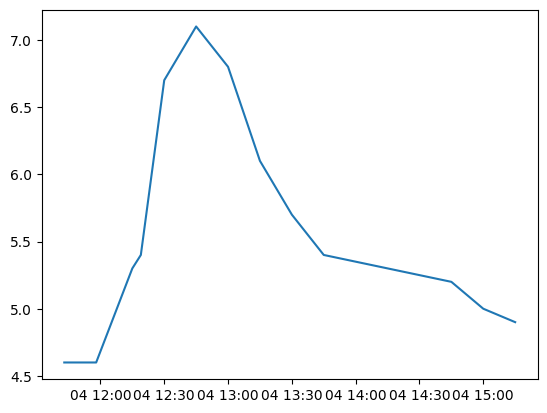

In [24]:
# Рассмотри график глюкозы для 1 приема пищи
result_df_max.loc[100:112, :]
plt.plot(result_df_max.loc[100:112, :]['Device Timestamp'], result_df_max.loc[100:112, :]['Scan Glucose mmol/L'])

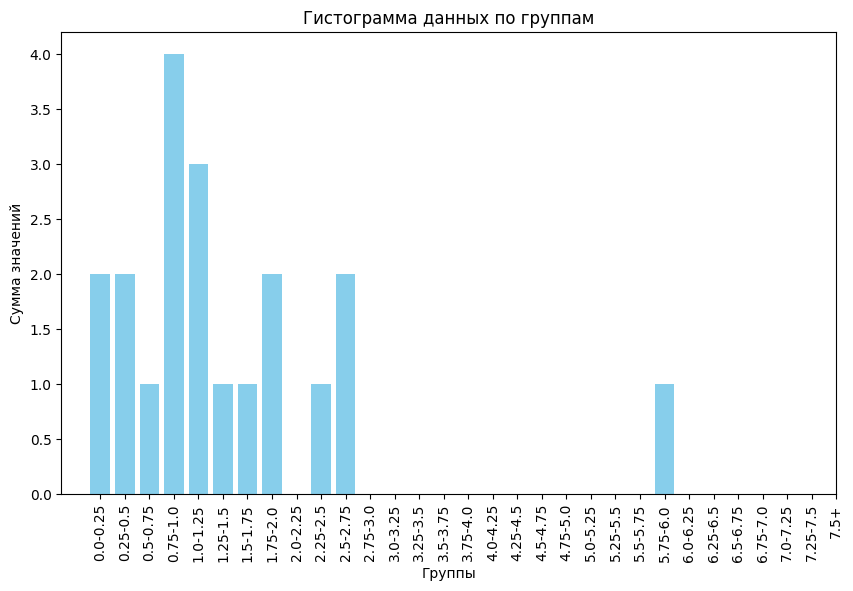

In [25]:
# Построим график вариационного ряда по признаку "Glucose max raise in Next 8 Rows"
def group_data(value):
    if value >= 7.5:
        return '7.5+'
    else:
        group = int(value / 0.25) * 0.25
        return f'{group}-{group + 0.25}'

viz_data = data_to_model.copy()

viz_data['Group'] = viz_data['Glucose max raise in Next 8 Rows'].apply(group_data)

grouped_data = viz_data.groupby('Group')['Glucose max raise in Next 8 Rows'].count().reindex([f'{i * 0.25}-{i * 0.25 + 0.25}' for i in range(30)] + ['7.5+'])
plt.figure(figsize=(10, 6))
plt.bar(range(len(grouped_data)), grouped_data, color='skyblue')
plt.xticks(range(len(grouped_data)), grouped_data.index)
plt.title('Гистограмма данных по группам')
plt.xlabel('Группы')
plt.ylabel('Сумма значений')
plt.xticks(rotation=90)
plt.show()

In [26]:
# Удаление выбросов не ведет к улучшению качества предсказания
#data_to_model_drop_outliers = data_to_model[data_to_model['Glucose max raise in Next 8 Rows'] < 3.75]
#len(data_to_model), len(data_to_model_drop_outliers)

In [27]:
#data_to_model_drop_outliers.head()

# ML

In [28]:
# Функция для сравнения нескольких моделей с подобием cross-validation
def eval_models(X, y, estimators_list, rs_number=50, cv=5):

  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler

  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error

  outliers = pd.DataFrame(columns=['model', 'dif', 'ind_X'])

  models_res = {}

  for i_model in estimators_list:
    print(i_model.__name__)

    # создадим модель
    if i_model.__name__ == 'CatBoostRegressor':
      model = i_model(iterations=100, verbose=False)
    elif i_model.__name__ == 'RandomForestRegressor':
      model = i_model(n_estimators=10, verbose=False)
    else:
      model = i_model()

    rs_result = pd.DataFrame(columns=['model', 'r2_test', 'rmse_test', 'mae_test'])
    for random_s in range(1, rs_number):

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_s)

   #   print(y_test)

      inds = y_test.index

      y_train = y_train.to_numpy().reshape(-1, 1)
      y_test = y_test.to_numpy().reshape(-1, 1)

      X_scaler = StandardScaler()
      y_scaler = StandardScaler()

      X_scaler.fit(X_train)
      X_test = X_scaler.transform(X_test)
      X_train = X_scaler.transform(X_train)

    #  y_scaler.fit(y_train)
    #  y_test = y_scaler.transform(y_test)
    #  y_train = y_scaler.transform(y_train)

    #  print(y_scaler.mean_, y_scaler.var_**0.5)

      # Обучим модель
      model.fit(X_train, y_train.flatten())

      # Предскажем значения на test и train выборках
      y_pred = model.predict(X_test)
      #y_pred_train = model.predict(X_train)

   #   y_pred = y_pred * (y_scaler.var_)**2 + y_scaler.mean_
   #   y_test = y_test * (y_scaler.var_)**2 + y_scaler.mean_

    #  y_pred[y_pred < 0] = 0
    #  print(y_pred)
    #  return 's'

      # Рассчитаем показатели точности для тестовой выборки
      r2_test = r2_score(y_test, y_pred)
      mae_test = mean_absolute_error(y_test, y_pred)
      rmse_test = mean_squared_error(y_test, y_pred) ** 0.5

      # Рассчитаем показатели точности для тренировочной выборки
      #r2_train = r2_score(y_train, y_pred_train)
      #mae_train = mean_absolute_error(y_train, y_pred_train)
      #rmse_train = mean_squared_error(y_train, y_pred_train) ** 0.5

      diffs = (y_test.flatten() - y_pred.flatten())
      for dif in diffs:
        if dif > 1 or dif < -1:
          outliers = pd.concat([outliers, pd.DataFrame.from_dict({'model': [i_model.__name__],
                                                                    'dif': [dif],
                                                                    'ind_X': [inds[np.where(diffs == dif)[0][0]]]})])

      # Оформим результаты в датафрейм
      rs_1_result = pd.DataFrame.from_dict({'model': [i_model.__name__],
                                              'rs': [random_s],
                                              'r2_test': [r2_test],
                                              'rmse_test': [rmse_test],
                                              'mae_test': [mae_test]})
                                          #    'r2_train': [mae_train],
                                          #    'rmse_train' : [rmse_test],
                                          #    'mae_train': [rmse_train]})

      # Объединим данные по экспериментам в датафрейм
      rs_result = pd.concat([rs_result, rs_1_result])

    model_res = pd.concat([rs_result.max(axis=0, numeric_only=True),
                           rs_result.min(axis=0),
                           rs_result.mean(axis=0, numeric_only=True),
                           rs_result.std(axis=0, numeric_only=True)], axis=1).drop(['rs', 'model'])
    model_res.columns = ['max', 'min', 'mean', 'std']
    models_res[i_model.__name__] = model_res

  return models_res, outliers

In [29]:
y = data_to_model['Glucose max raise in Next 8 Rows']
X = data_to_model.drop(columns=['Glucose max raise in Next 8 Rows', 'iAUC'])

X = pd.get_dummies(X)

In [30]:
#!pip install catboost

In [31]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
#from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor


models_res, outliers = eval_models(X, y, [KNeighborsRegressor, ElasticNet, SVR, DecisionTreeRegressor, RandomForestRegressor], rs_number=20)

KNeighborsRegressor
ElasticNet
SVR
DecisionTreeRegressor
RandomForestRegressor


In [32]:
models_res

{'KNeighborsRegressor':                 max       min      mean       std
 r2_test    0.797459 -3.819237 -0.243694  1.130591
 rmse_test  1.178643   0.26047  0.666994  0.242499
 mae_test   1.090000      0.25  0.561842  0.206060,
 'ElasticNet':                 max        min      mean       std
 r2_test    0.669401 -20.671112 -1.133880  4.755375
 rmse_test  1.038443    0.31907  0.730441  0.198219
 mae_test   0.975071   0.316611  0.661037  0.191895,
 'SVR':                 max        min      mean       std
 r2_test    0.582873 -16.565203 -1.123007  3.791110
 rmse_test  1.275556   0.235033  0.797457  0.271396
 mae_test   1.132906   0.225314  0.668424  0.244339,
 'DecisionTreeRegressor':                 max        min      mean       std
 r2_test    0.847923 -15.458015 -3.258196  4.585630
 rmse_test  1.979408    0.35473  1.107732  0.470395
 mae_test   1.575000      0.325  0.907018  0.365552,
 'RandomForestRegressor':                 max       min      mean       std
 r2_test    0.596084 -7

## tests

In [ ]:
#
def train_pred_model(model, X, y, rs=1):
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler

  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

  inds_test = y_test.index
  inds_train = y_train.index

  y_train = y_train.to_numpy().reshape(-1, 1)
  y_test = y_test.to_numpy().reshape(-1, 1)

  X_scaler = StandardScaler()
  y_scaler = StandardScaler()

  X_scaler.fit(X_train)
  X_test = X_scaler.transform(X_test)
  X_train = X_scaler.transform(X_train)

  y_scaler.fit(y_train)
  y_test = y_scaler.transform(y_test)
  y_train = y_scaler.transform(y_train)

  # Обучим модель
  model.fit(X_train, y_train.flatten())

  # Предскажем значения на test и train выборках
  y_pred = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  y_pred = y_pred * (y_scaler.var_)**2 + y_scaler.mean_
  y_pred_train = y_pred_train * (y_scaler.var_)**2 + y_scaler.mean_

#  y_pred[y_pred < 0] = 0
#  y_pred_train[y_pred_train < 0] = 0

  y_pred = pd.Series(y_pred)
  y_pred.index = inds_test
  y_pred_train = pd.Series(y_pred_train)
  y_pred_train.index = inds_train

  y_test = y_test.flatten()
  y_test = pd.Series(y_test)
  y_test.index = inds_test

  return y_pred, y_pred_train, y_test, y_scaler

In [ ]:
model = SVR()
y_pred, y_pred_train, y_test, y_s = train_pred_model(model, X, y, rs=1)

In [ ]:
y_s.mean_, y_s.var_

(array([1.9877551]), array([2.63957795]))

In [ ]:
data_to_model.merge(y_pred.rename('y_pred'), how='left', left_index=True, right_index=True).dropna()#.merge(y_pred_train.rename('y_pred_train'), how='left', left_index=True, right_index=True).dropna()

,ккал,белки,жиры,углеводы,Glucose max raise in Next 8 Rows,iAUC,carb prop,y_pred
24,397.00,35.187500,24.187500,22.437500,0.833333,1.566667,27.421875,-2.942013
233,606.00,20.828125,35.937500,48.968750,0.900000,-0.500000,46.312500,-1.330741
266,584.50,37.687500,23.593750,51.406250,1.333333,7.766667,45.625000,-1.560545
288,464.00,48.843750,8.523438,47.718750,3.833333,17.866667,45.406250,-1.322080
387,467.50,2.550781,28.906250,48.968750,1.866667,9.733333,60.875000,1.050793
420,1018.50,80.312500,43.468750,72.250000,3.200000,12.100000,36.875000,2.367821
431,1017.50,66.062500,41.843750,102.125000,6.433333,32.766667,48.625000,2.636962
453,609.00,36.000000,29.906250,49.000000,4.266667,12.933333,42.656250,-1.854627
464,458.50,42.375000,22.578125,22.765625,0.933333,3.866667,25.953125,-2.462340
486,492.25,49.843750,21.062500,22.453125,1.600000,-1.500000,24.046875,-1.650147


In [ ]:
outliers = outliers.groupby(by=['model', 'ind_X']).agg(['count', 'max', 'mean', 'std'])
outliers.columns = outliers.columns.droplevel(0)

# Работа с выбросами

In [ ]:
outliers.loc['ElasticNet'].sort_values(by='count', ascending=False).head(20)

,count,max,mean,std
ind_X,,,,
343,8,-1.319355,-1.513641,0.113619
409,7,2.300630,2.154079,0.087146
453,6,2.450073,2.356636,0.082295
310,6,-1.534948,-1.605898,0.056041
277,6,-1.084658,-1.210079,0.094506
321,5,3.449300,3.242392,0.131275
442,5,-1.031315,-1.186228,0.151373
79,5,-1.418086,-1.606825,0.138223
365,5,-1.861700,-1.980048,0.120032


In [ ]:
data_to_model.loc[321]

ккал                                521.500000
белки                                24.468750
жиры                                  6.292969
углеводы                             89.875000
Glucose max raise in Next 8 Rows      5.466667
iAUC                                 29.233333
carb prop                            74.500000
Name: 321, dtype: float64

In [ ]:
data_to_model.loc[310]

ккал                                741.000000
белки                                55.437500
жиры                                 41.218750
углеводы                             33.687500
Glucose max raise in Next 8 Rows      0.333333
iAUC                                 -0.433333
carb prop                            25.843750
Name: 310, dtype: float64

In [ ]:
data_to_model.loc[409]

ккал                                1012.50000
белки                                 46.84375
жиры                                  61.50000
углеводы                              70.75000
Glucose max raise in Next 8 Rows       4.30000
iAUC                                  23.70000
carb prop                             39.50000
Name: 409, dtype: float64

In [ ]:
data_to_model.loc[79]

ккал                                5.359375
белки                                    0.0
жиры                                0.008003
углеводы                            1.847656
Glucose max raise in Next 8 Rows    0.133333
iAUC                               -0.433333
Time of Day                            вечер
Name: 79, dtype: object

In [ ]:
data_to_model.loc[673]

ккал                                   1040.0
белки                                  55.375
жиры                                24.546875
углеводы                              145.625
Glucose max raise in Next 8 Rows          5.0
iAUC                                     31.0
Time of Day                              день
Name: 673, dtype: object

## 321.

1. Лапша японская, сомен, приготовленная: 210 г, ккал 275.1, белки 8.4, жиры 0.378 , углеводы 57.834
2. Куриная грудка (филе) (Варка): 57 г, ккал 55.1988, белки 11.97, жиры 0.71478 , углеводы 0.228
3. Шоколадный Ролл с Фруктами [Тануки]: 1 штука, ккал 191, белки 4.1, жиры 5.2 , углеводы 31.8

In [ ]:
data_to_model.loc[321]

ккал                                    521.5
белки                                24.46875
жиры                                 6.292969
углеводы                               89.875
Time of Day                              день
Glucose max raise in Next 8 Rows     5.466667
iAUC                                29.233333
carb prop                           74.497118
Name: 321, dtype: object

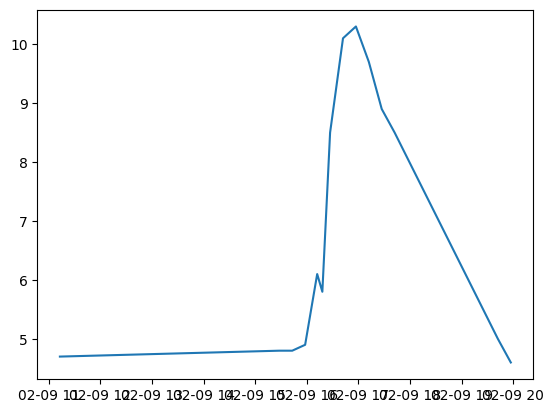

In [ ]:
plt.plot(result_df_max.loc[318:331, :]['Device Timestamp'], result_df_max.loc[318:331, :]['Scan Glucose mmol/L'])